In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.optimize

In [14]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/var/folders/pg/9b4jm_x17t9_7br0mxk3vcy00000gn/T/ipykernel_89078/2106068084.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [56]:
sns.set_theme()

In [16]:
def load(path):
    samples = pd.read_csv(path)
    samples['observer_angle'] = np.rad2deg(samples['observer_angle'])
    return samples

In [17]:
samples_0 = load('samples/0.csv')
samples_q_uniform = load('samples/q_uniform.csv')
samples_q_inv = load('samples/q_inv.csv')

samples = pd.concat(
    [samples_q_inv, samples_q_uniform, samples_0],
    keys=['$q$ ~ Uniform', '$q^{-1}$ ~ Uniform', r'$m_\text{giant}, m_\text{dwarf}$ ~ Uniform'],
    names=['model']
)

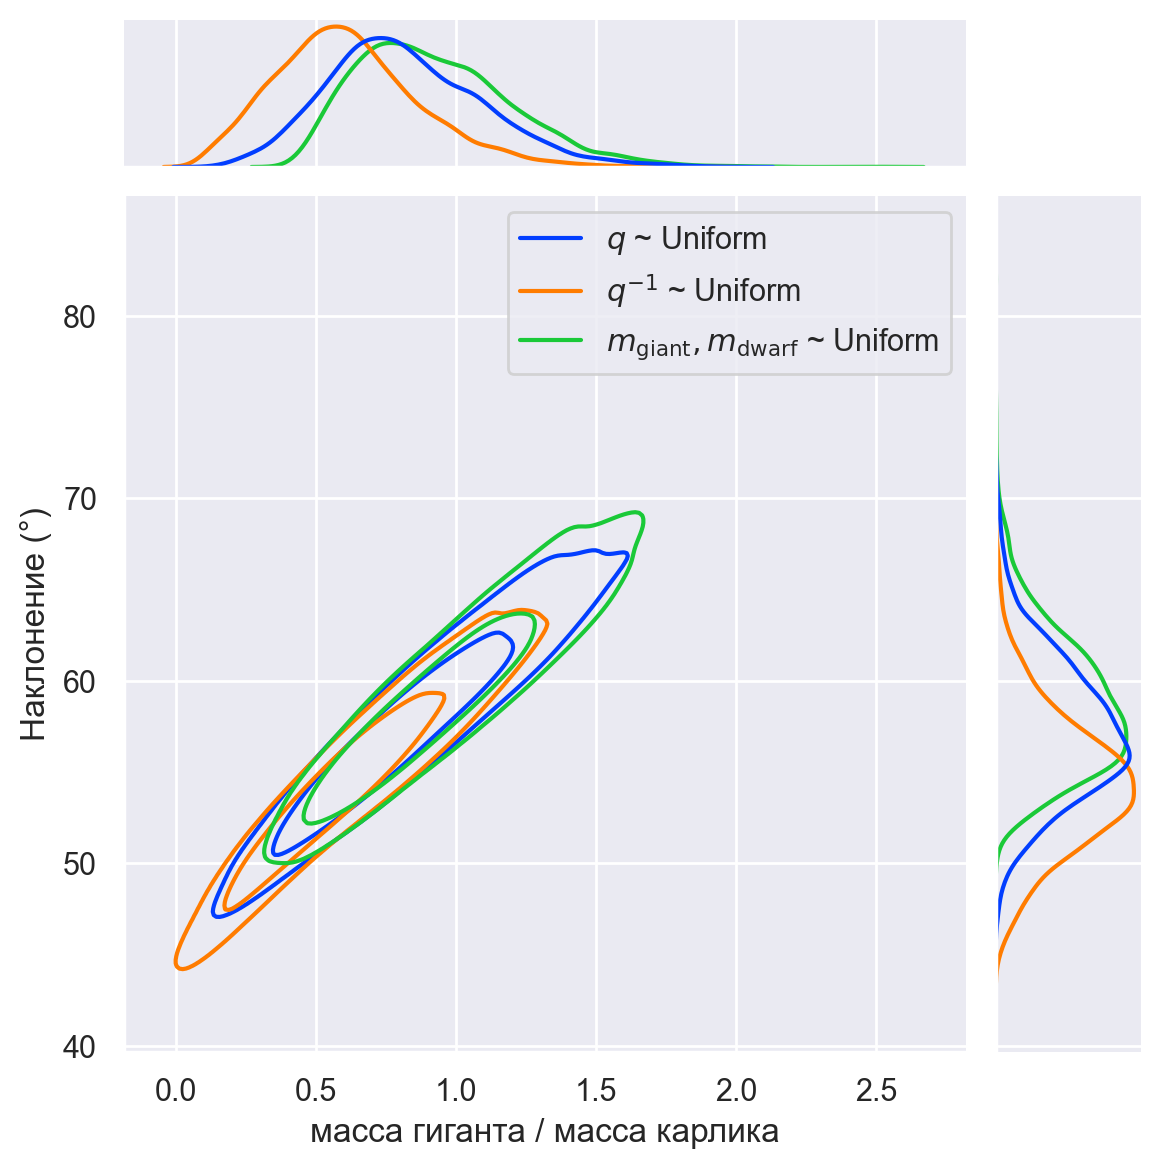

In [87]:
joint_grid = sns.jointplot(
    samples,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    kind = 'kde',
    joint_kws={'levels': [0.05, 0.32, 1], 'common_norm': False, 'bw_adjust': 1.5},
    marginal_kws={'common_norm': False},
)

joint_grid.ax_joint.legend_.set_title(None)
joint_grid.set_axis_labels('масса гиганта / масса карлика', 'Наклонение (°)')

In [ ]:
def get_max_point(samples):
    dist = scipy.stats.gaussian_kde([samples['mass_quotient_inv'], samples['observer_angle']])
    return scipy.optimize.minimize(lambda x: -dist(x), (0.7, 55)).x

In [ ]:
# (deep, muted, bright, pastel, dark, colorblind)

In [84]:
sns.set_palette('bright')

(45.0, 70.0)

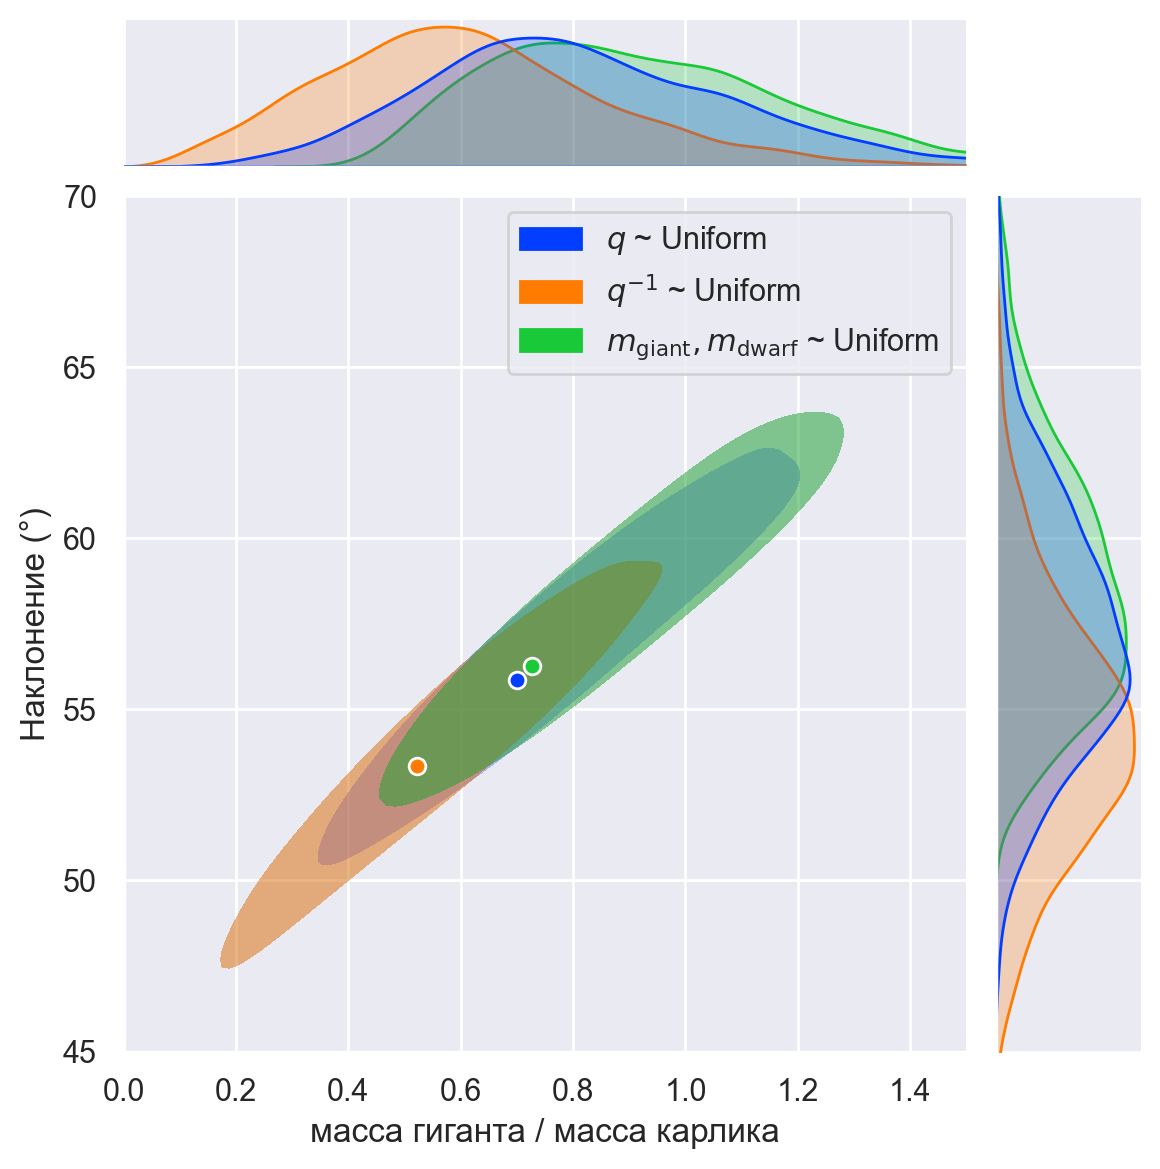

In [89]:
joint_grid = sns.jointplot(
    samples,
    x = 'mass_quotient_inv',
    y = 'observer_angle',
    hue='model',
    kind = 'kde',
    joint_kws={'fill': True, 'levels': [0.32, 1], 'alpha': 0.5, 'common_norm': False, 'bw_method': 'silverman', 'bw_adjust': 1.5},
    marginal_kws={'common_norm': False},
)

joint_grid.ax_joint.scatter(*get_max_point(samples_q_inv), edgecolors='white')
joint_grid.ax_joint.scatter(*get_max_point(samples_q_uniform), edgecolors='white')
joint_grid.ax_joint.scatter(*get_max_point(samples_0), edgecolors='white')


joint_grid.ax_joint.legend_.set_title(None)
joint_grid.set_axis_labels('масса гиганта / масса карлика', 'Наклонение (°)')
joint_grid.ax_joint.set_xlim(0, 1.5)
joint_grid.ax_joint.set_ylim(45, 70)

In [90]:
joint_grid.savefig('tex/pic_drafts/angle_mass_quotient.pdf')